In [1]:
!pip install tensorflow==2.0.0

In [2]:
!pip install tensorflow_probability==0.8.0

In [0]:
import numpy as np
import urllib
import os
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import tensorflow as tf
%matplotlib inline
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation, Dropout, Input, Concatenate
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras import optimizers
tfd = tfp.distributions


In [4]:
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFP Version 0.8.0
TF  Version 2.0.0


In [0]:
if not os.path.isfile('X_faces.npy'):
    urllib.request.urlretrieve(
    "https://www.dropbox.com/s/5m7nmebpjysqtus/X_faces.npy?dl=1",
    "X_faces.npy")

if not os.path.isfile('Y_age.npy'):
    urllib.request.urlretrieve(
    "https://www.dropbox.com/s/flpyvgdqoatdw0g/Y_age.npy?dl=1",
    "Y_age.npy")


In [0]:
X=np.load("X_faces.npy")
Y=np.load("Y_age.npy")

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=201)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=34)

In [8]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(10642, 80, 80, 3)
(5242, 80, 80, 3)
(7824, 80, 80, 3)


In [0]:
X_train=X_train/255
X_val=X_val/255
X_test=X_test/255

In [0]:
X_train = np.array(X_train,dtype="float32")
X_val = np.array(X_val,dtype="float32")
X_test = np.array(X_test,dtype="float32")

y_train = np.array(y_train,dtype="float32")
y_val = np.array(y_val,dtype="float32")
y_test = np.array(y_test,dtype="float32")

In [0]:
kernel_size = (3, 3)
pool_size = (2, 2)

In [0]:
def NLL(y, distr):
  return -distr.log_prob(y) 

def my_dist(params): 
  return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))# both parameters are learnable

input1 = Input(shape=(80,80,3))
input2 = Input(shape=(1,))
x = Convolution2D(16,kernel_size,padding='same',activation="relu")(input1)
x = Convolution2D(16,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Flatten()(x)
x = Dense(500,activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(50,activation="relu")(x)
x = Dropout(0.3)(x)
out1 = Dense(1)(x)
out2 = Dense(1,use_bias=False)(input2) 
params = Concatenate()([out1,out2]) 
dist = tfp.layers.DistributionLambda(my_dist)(params) #

model_const_sd = Model(inputs=[input1,input2], outputs=dist) ## use a trick with two inputs, input2 is just ones
model_const_sd.compile(tf.keras.optimizers.Adam(), loss=NLL) 

In [15]:
# train the model
history=model_const_sd.fit([X_train,np.expand_dims(np.ones(len(X_train)),1)], y_train, 
                    batch_size=128, 
                    epochs=3,
                    verbose=1, 
                    validation_data=([X_val,np.expand_dims(np.ones(len(X_val)),1)], y_val)
                  )


Train on 10642 samples, validate on 5242 samples
Epoch 1/3
10642/10642 [==============================] - 159s 15ms/sample - loss: 474.3455 - val_loss: 433.8329
Epoch 2/3
10642/10642 [==============================] - 159s 15ms/sample - loss: 444.3102 - val_loss: 477.1659
Epoch 3/3
10642/10642 [==============================] - 159s 15ms/sample - loss: 396.6374 - val_loss: 341.9475


In [0]:
model_const_sd_mean = Model(inputs=[input1,input2], outputs=dist.mean())
model_const_sd_sd = Model(inputs=[input1,input2], outputs=dist.stddev())

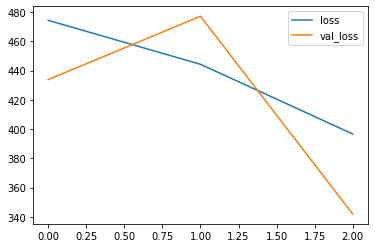

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

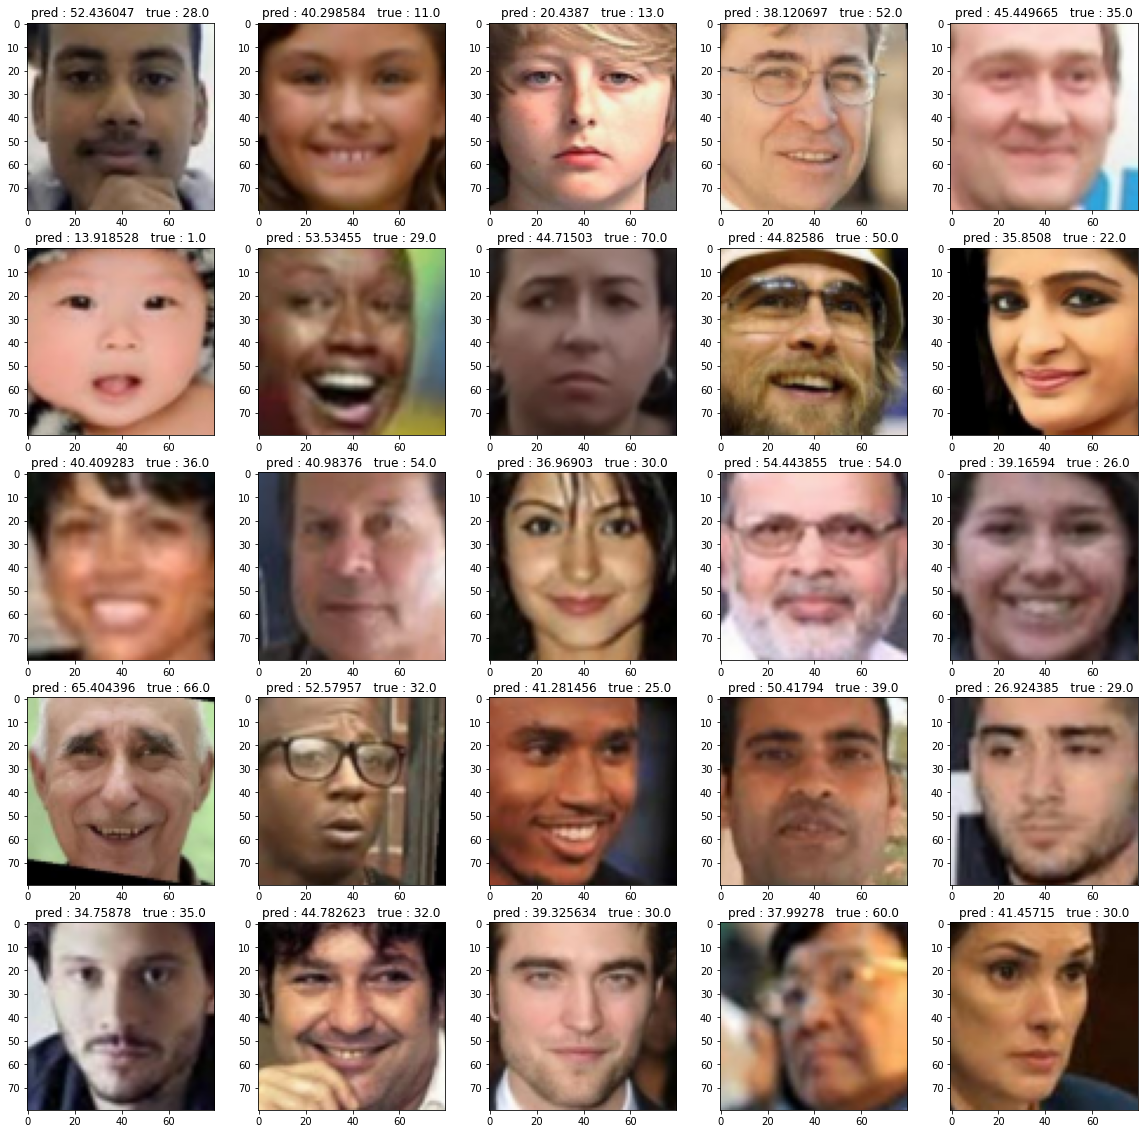

In [20]:
plt.figure(figsize=(20,20))
for i in range(0,25):
    plt.subplot(5,5,i+1)
    plt.imshow(X_test[i])
    plt.title("pred : "+ np.str(model_const_sd_mean.predict([X_test[i:i+1],np.expand_dims(np.ones(len(X_test[i:i+1])),1)])[0][0]) + "   true : "+ np.str(y_test[i]))

[[52.436047]]
[[0.692363]]


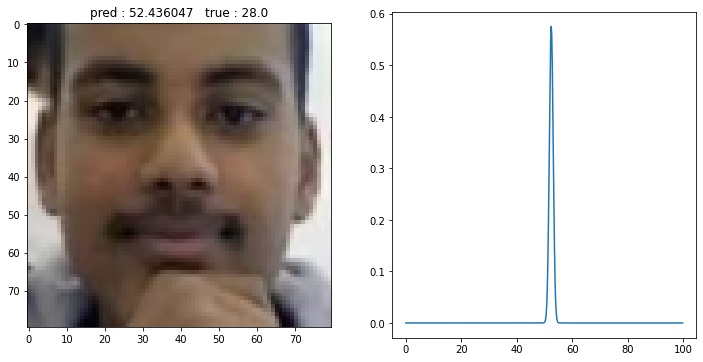

[[40.298584]]
[[0.692363]]


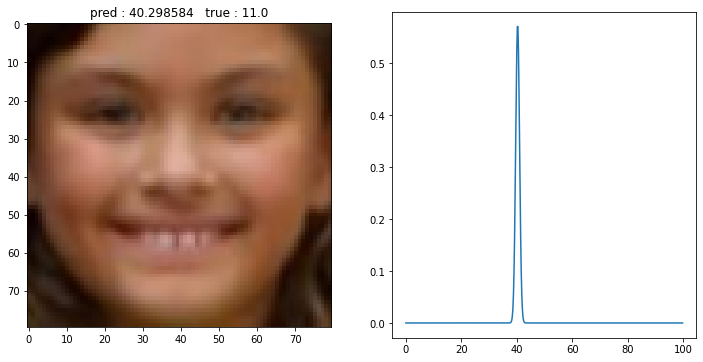

[[20.4387]]
[[0.692363]]


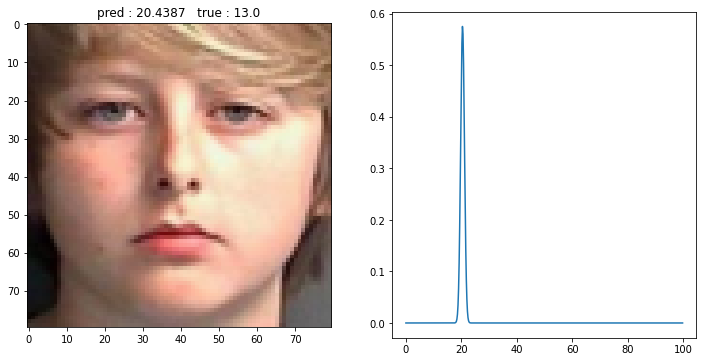

[[38.120697]]
[[0.692363]]


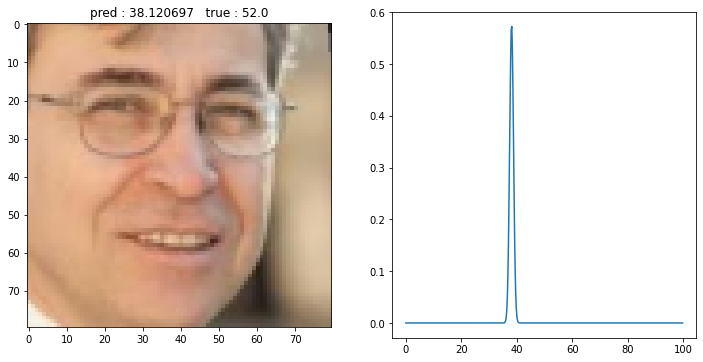

[[45.449665]]
[[0.692363]]


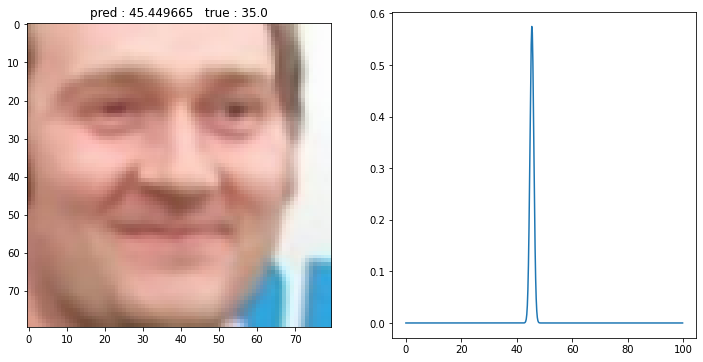

[[13.918528]]
[[0.692363]]


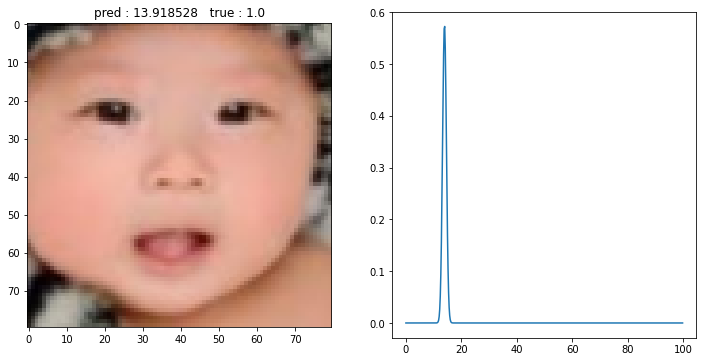

[[53.53455]]
[[0.692363]]


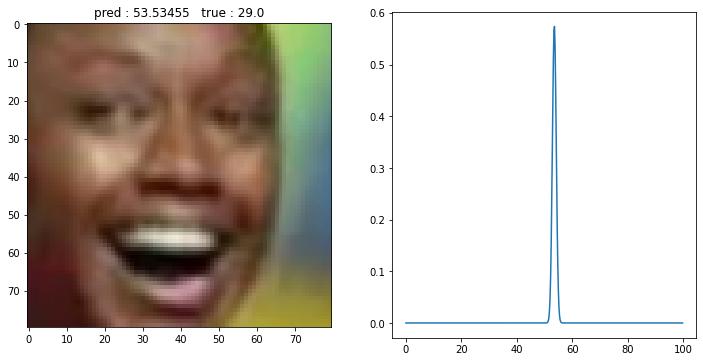

[[44.71503]]
[[0.692363]]


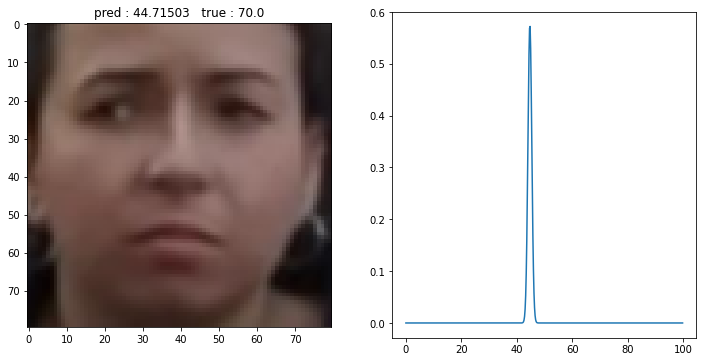

[[44.82586]]
[[0.692363]]


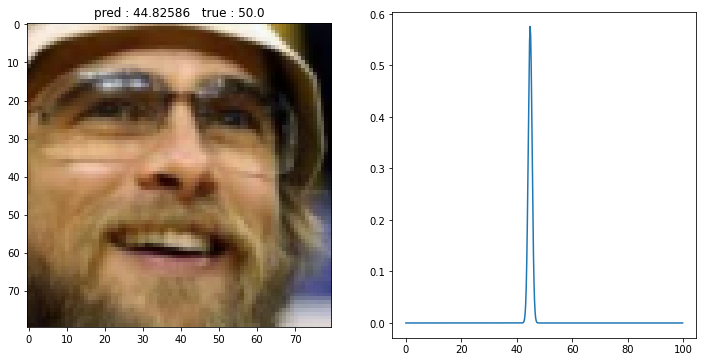

[[35.8508]]
[[0.692363]]


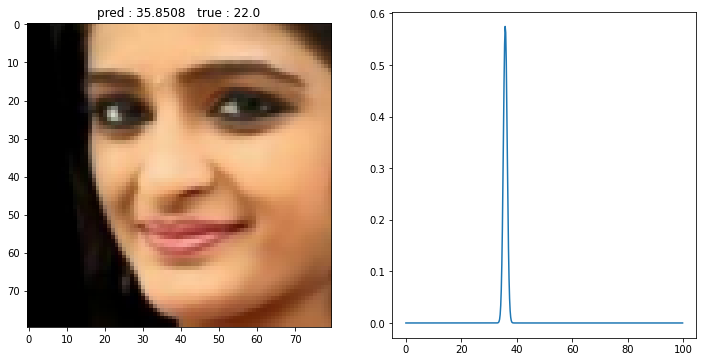

In [22]:
for i in range(0,10):
  plt.figure(figsize=(12,6))
  plt.subplot(1,2,1)
  plt.imshow(X_test[i])
  plt.title("pred : "+ np.str(model_const_sd_mean.predict([X_test[i:i+1],np.expand_dims(np.ones(len(X_test[i:i+1])),1)])[0][0]) + "   true : "+ np.str(y_test[i]))
  print(model_const_sd_mean.predict([X_test[i:i+1],np.expand_dims(np.ones(len(X_test[i:i+1])),1)]))
  print(model_const_sd_sd.predict([X_test[i:i+1],np.expand_dims(np.ones(len(X_test[i:i+1])),1)]))
  d = tfd.Normal(loc=model_const_sd_mean.predict([X_test[i:i+1],np.expand_dims(np.ones(len(X_test[i:i+1])),1)]), scale=model_const_sd_sd.predict([X_test[i:i+1],np.expand_dims(np.ones(len(X_test[i:i+1])),1)]))           #A
  plt.subplot(1,2,2)
  plt.plot(np.arange(0,100,0.2),d.prob(np.arange(0,100,0.2))[0])
  plt.show()

In [23]:
preds_train = model.predict(X_train)
SSR= np.sum(np.square(y_train-preds_train))
sigma_=np.sqrt((SSR)/(len(X_train)-2))
sigma_

NameError: ignored

In [24]:
#loss with the estimated sigma
NLL_train=np.mean(-np.log(1/(np.sqrt(2*np.pi*np.square(sigma_))))+
                  ((np.square(y_train-model.predict(X_train))/(2*np.square(sigma_)))))
print(NLL_train)
NLL_val=np.mean(-np.log(1/(np.sqrt(2*np.pi*np.square(sigma_))))+
                ((np.square(y_val-model.predict(X_val))/(2*np.square(sigma_)))))
print(NLL_val)

NLL_test=np.mean(-np.log(1/(np.sqrt(2*np.pi*np.square(sigma_))))+
                ((np.square(y_val-model.predict(X_test))/(2*np.square(sigma_)))))
print(NLL_test)

NameError: ignored

In [0]:

def NLL(y, distr):
  return -distr.log_prob(y) 

def my_dist(params): 
  return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))# both parameters are learnable

inputs = Input(shape=(80,80,3))
x = Convolution2D(16,kernel_size,padding='same',activation="relu")(inputs)
x = Convolution2D(16,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Flatten()(x)
x = Dense(500,activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(50,activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(2)(x)
dist = tfp.layers.DistributionLambda(my_dist)(x) 

model_flex = Model(inputs=inputs, outputs=dist)
model_flex.compile(tf.keras.optimizers.Adam(), loss=NLL) 


In [27]:
# train the model
history=model_flex.fit(X_train, np.array(y_train,dtype="float32"), 
                  batch_size=32, 
                  epochs=30,
                  verbose=1, 
                  validation_data=(X_val, np.array(y_val,dtype="float32")))


Train on 10642 samples, validate on 5242 samples
Epoch 1/30
10642/10642 [==============================] - 161s 15ms/sample - loss: 26.2919 - val_loss: 4.4790
Epoch 2/30
10642/10642 [==============================] - 161s 15ms/sample - loss: 4.6892 - val_loss: 4.4407
Epoch 3/30
10642/10642 [==============================] - 160s 15ms/sample - loss: 4.6008 - val_loss: 4.4190
Epoch 4/30
 1760/10642 [===>..........................] - ETA: 1:57 - loss: 4.6708

KeyboardInterrupt: ignored

In [0]:
model_mean = Model(inputs=inputs, outputs=dist.mean())
model_sd = Model(inputs=inputs, outputs=dist.stddev())

In [31]:
model_flex.evaluate(X_train,y_train,verbose=0)

4.444767471274763

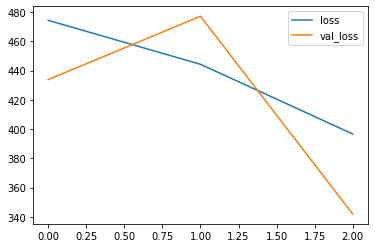

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

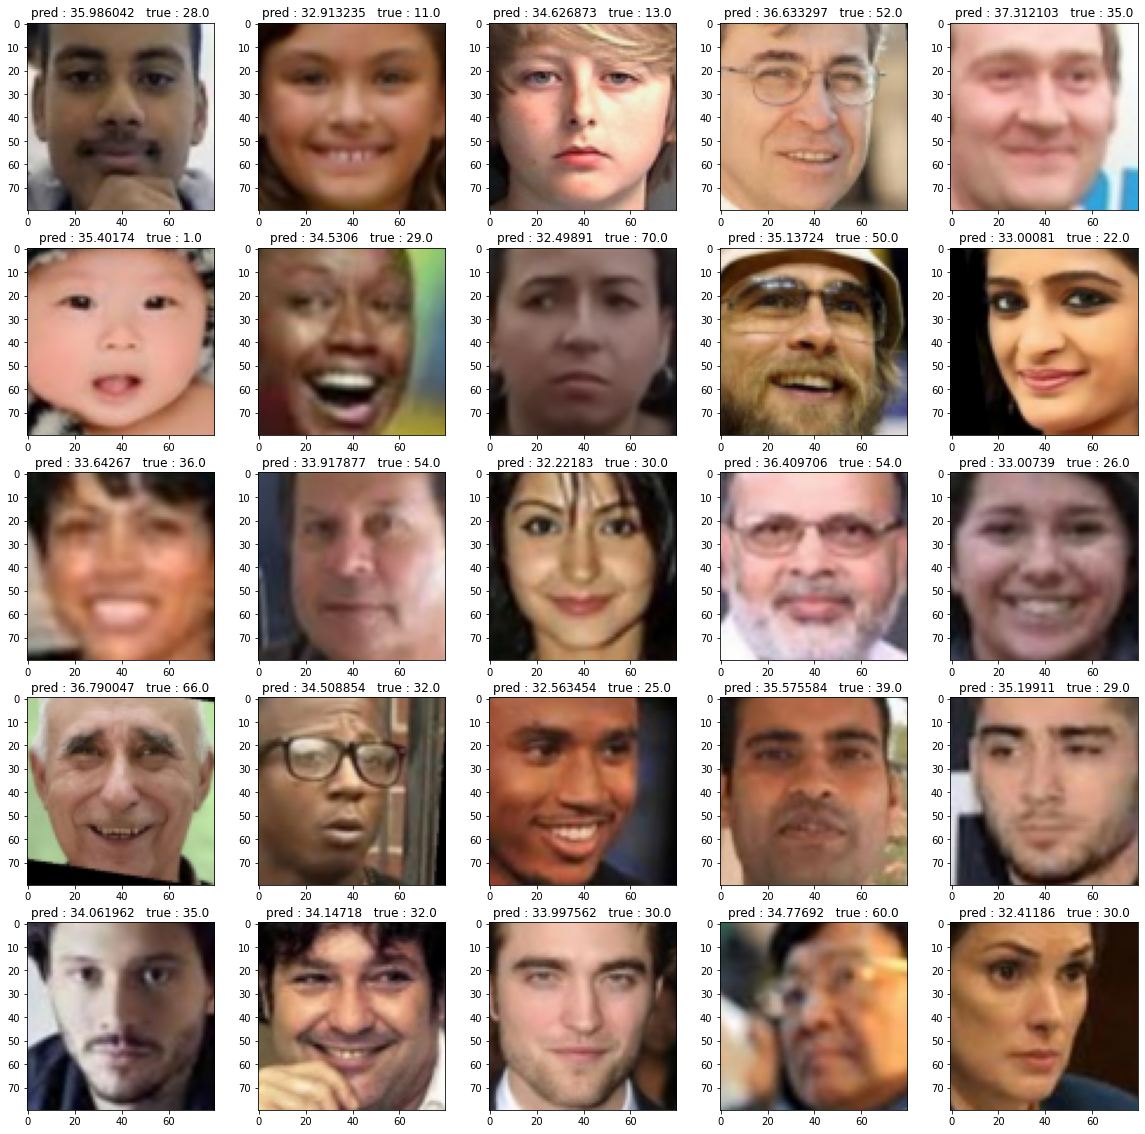

In [33]:
plt.figure(figsize=(20,20))
for i in range(0,25):
    plt.subplot(5,5,i+1)
    plt.imshow(X_test[i])
    plt.title("pred : "+ np.str(model_mean.predict(X_test[i:i+1])[0][0]) + "   true : "+ np.str(y_test[i]))

[[35.986042]]
[[25.7923]]


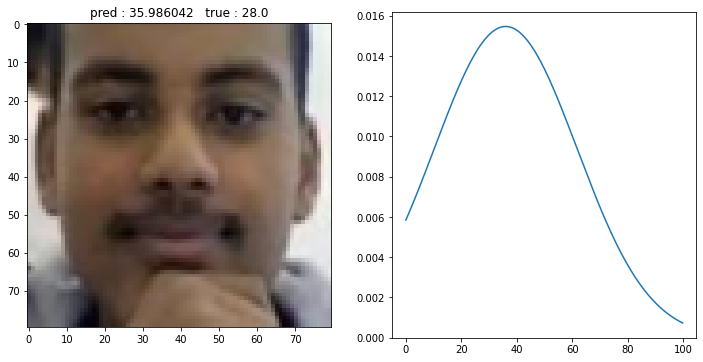

[[32.913235]]
[[23.556656]]


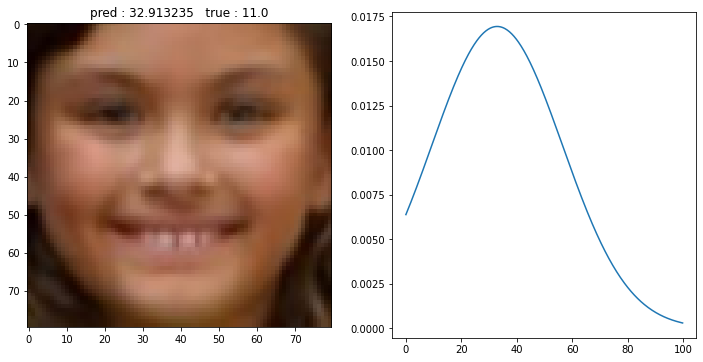

[[34.626873]]
[[24.731853]]


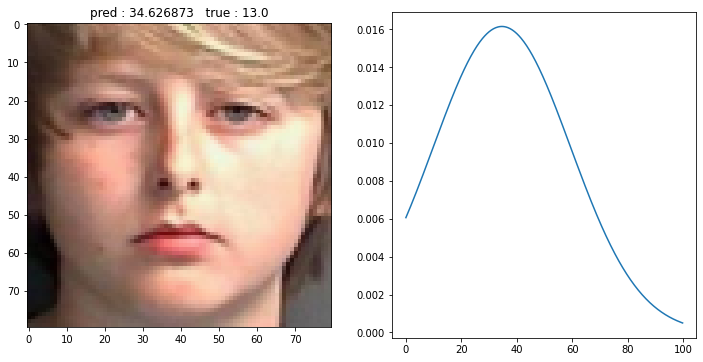

[[36.633297]]
[[26.22051]]


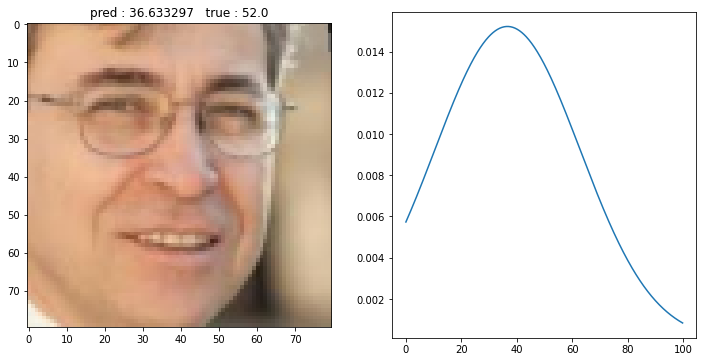

[[37.312103]]
[[26.630669]]


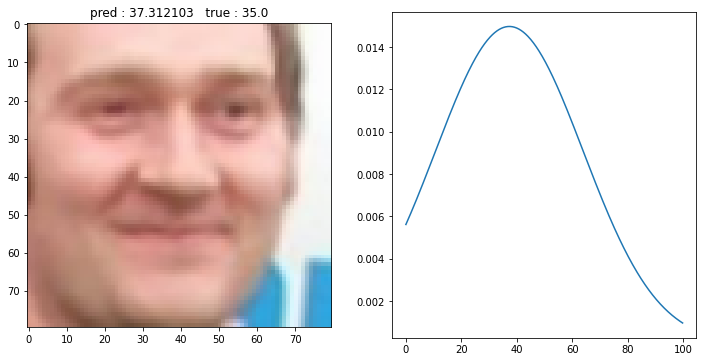

[[35.40174]]
[[25.369179]]


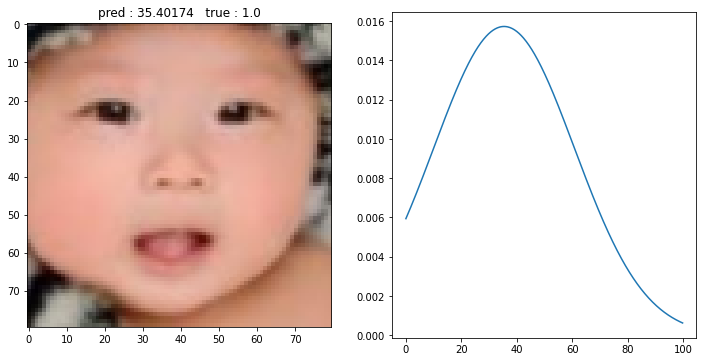

[[34.5306]]
[[24.645899]]


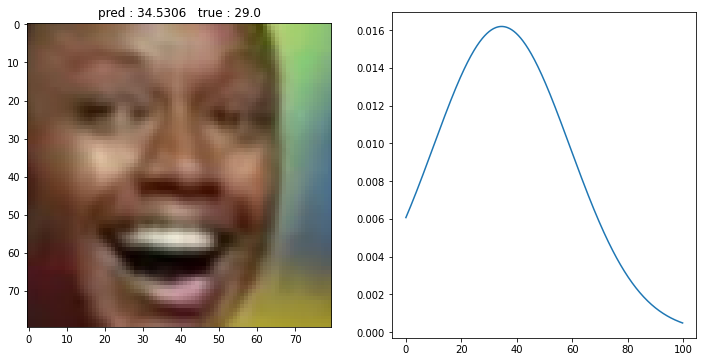

[[32.49891]]
[[23.271564]]


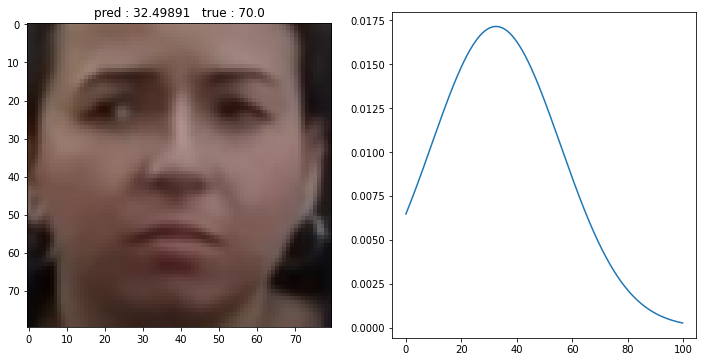

[[35.13724]]
[[25.150875]]


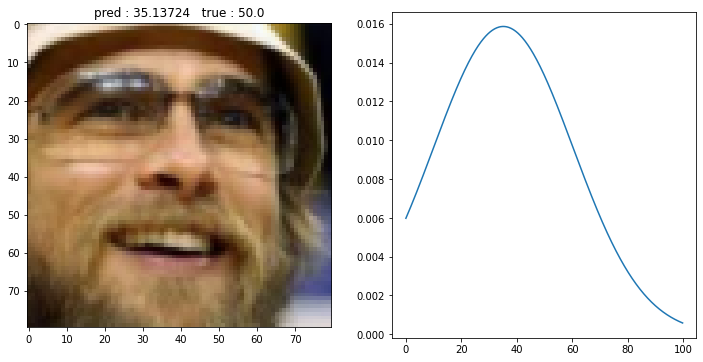

[[33.00081]]
[[23.551704]]


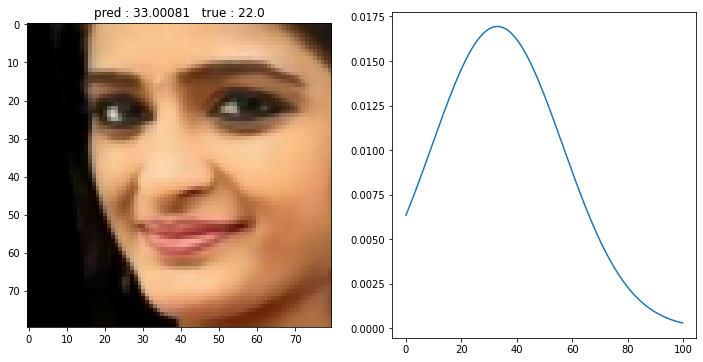

In [34]:
for i in range(0,10):
  plt.figure(figsize=(12,6))
  plt.subplot(1,2,1)
  plt.imshow(X_test[i])
  plt.title("pred : "+ np.str(model_mean.predict(X_test[i:i+1])[0][0]) + "   true : "+ np.str(y_test[i]))
  print(model_mean.predict(X_test[i:i+1]))
  print(model_sd.predict(X_test[i:i+1]))
  d = tfd.Normal(loc=model_mean.predict(X_test[i:i+1]), scale=model_sd.predict(X_test[i:i+1]))           #A
  plt.subplot(1,2,2)
  plt.plot(np.arange(0,100,0.2),d.prob(np.arange(0,100,0.2))[0])
  plt.show()